## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import preprocessing

import dill

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, SVGD, RBFSteinKernel, Trace_ELBO, NUTS, MCMC
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


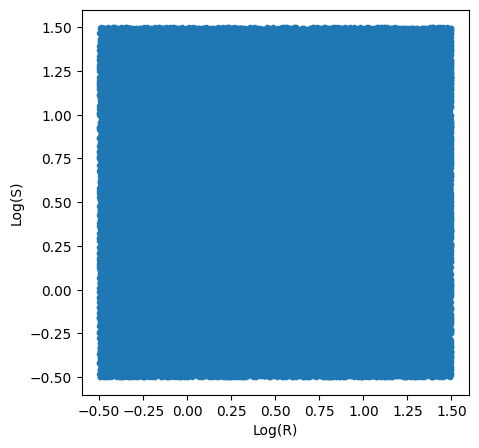

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 300, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Training Parameters

In [3]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "residual_blocks": 1,
    "layer_per_residual": 1,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.05], device=device)
}

## Defining Data Sets and Scaling

In [4]:
x_scaler = preprocessing.StandardScaler().fit(etas_train)
y_scaler = preprocessing.StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_scaled_test = x_scaler.transform(etas_test)
y_scaled_test = y_scaler.transform(gs_test)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaled_test, dtype=torch.float32)
y_test = torch.tensor(y_scaled_test, dtype=torch.float32)

x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

## Training

In [10]:
model = TurbulenceNetworkBayesian(**model_params)

tree_depth = 15

sampler_params = {
    "warmup_steps": 20,
    "num_samples": 50,
    "num_chains": 3
}

nuts_kernel = NUTS(model, max_tree_depth=tree_depth)
mcmc = MCMC(nuts_kernel, mp_context="spawn", **sampler_params)

mcmc.run(x_train, y_train)
mcmc.summary()

Warmup [1]:   0%|          | 0/70 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/70 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/70 [00:00, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/home/codygrogan/.local/lib/python3.12/site-packages/torch/__init__.py:725: UserWa


                                            mean       std    median      5.0%     95.0%     n_eff     r_hat
      layers.0.layers.0.linear.bias[0]     -1.15      0.84     -1.72     -1.76      0.04      1.52    886.40
      layers.0.layers.0.linear.bias[1]     -0.94      0.34     -0.95     -1.36     -0.52      1.52    485.01
      layers.0.layers.0.linear.bias[2]      0.71      0.45      0.76      0.14      1.23      1.52    632.15
      layers.0.layers.0.linear.bias[3]      0.54      0.21      0.61      0.25      0.76      1.52    996.47
      layers.0.layers.0.linear.bias[4]     -0.26      1.27     -0.85     -1.43      1.51      1.52   3382.46
      layers.0.layers.0.linear.bias[5]     -0.33      0.90      0.08     -1.57      0.50      1.52   1898.14
      layers.0.layers.0.linear.bias[6]     -0.80      0.67     -0.73     -1.66     -0.01      1.52   1831.78
      layers.0.layers.0.linear.bias[7]      0.17      1.13     -0.04     -1.09      1.64      1.52   1286.95
      layers.0.lay

## Saving MCMC Run

In [11]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}"
save_MCMC_model(mcmc, "./Model_Checkpoints", save_name)


## Loading MCMC Run

Warmup [1]:   0%|          | 0/70 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/70 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/70 [00:00, ?it/s]

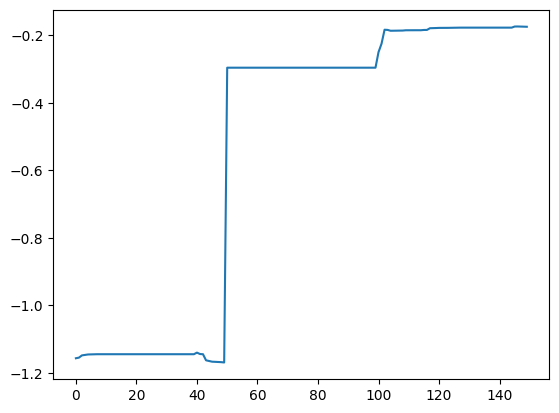

In [12]:
save_name = f"MCMC_model_{sampler_params['num_samples']}_{sampler_params['warmup_steps']}_{tree_depth}_{sampler_params['num_chains']}"


model = TurbulenceNetworkBayesian(**model_params)
kernel = NUTS(model, max_tree_depth=tree_depth)

mcmc_test = load_MCMC_model("./Model_Checkpoints", save_name, kernel, sampler_params)

samples = mcmc_test.get_samples()

stem = samples['stem.weight']

param = stem

for i in range(1):
    plt.plot(stem[:, i, 0].cpu().numpy(), label=f"Weight {i}, {0}")

## Plotting Samples

tensor(0.0550, dtype=torch.float64)


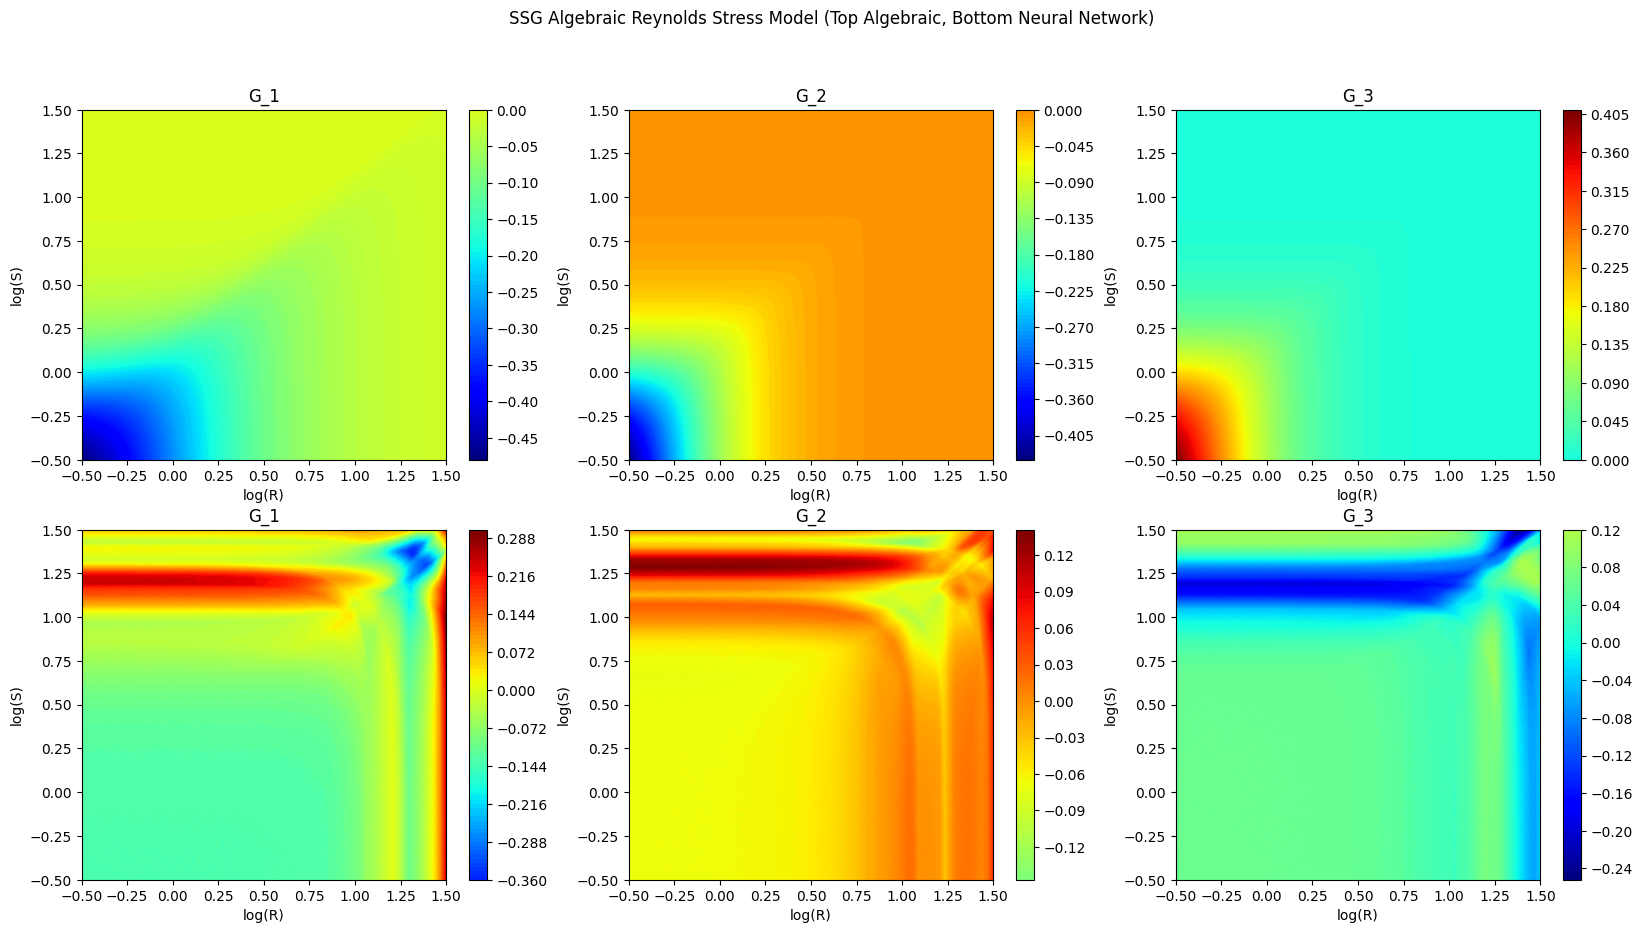

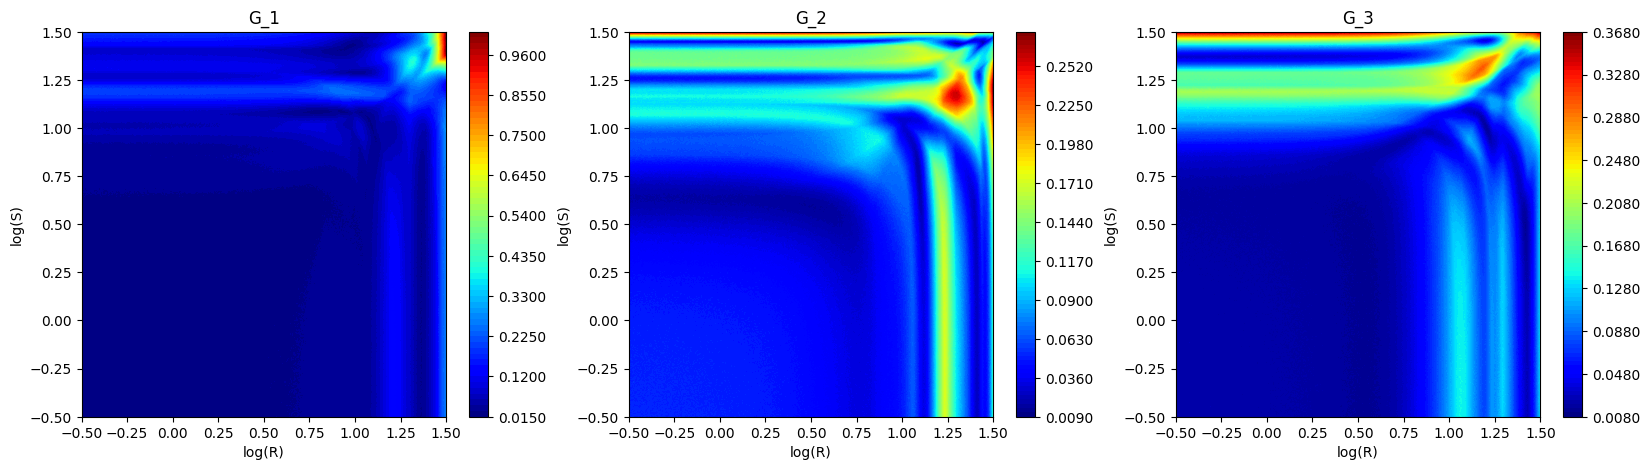

In [14]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model, posterior_samples=mcmc_test.get_samples(), return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu().numpy()
pred_std = torch.std(pred, axis=0).detach().cpu().numpy()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))